In [1]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import nltk
import numpy as np
import re
from time import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

C:\Users\Tarunbir Singh\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
fake_news = pd.read_csv("Kaggle_dataset/fake_13k.csv" , usecols=["uuid","author","title","text","country","type","language"])

In [4]:
fake_news.head(5)

,uuid,author,title,text,language,country,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,Barracuda Brigade,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,US,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,reasoning with facts,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,US,bias
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,Barracuda Brigade,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,US,bias
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,Fed Up,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,US,bias
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,Fed Up,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,US,bias


In [3]:
fake_news.groupby(["type"]).size()

type
bias            443
bs            11492
conspiracy      430
fake             19
hate            246
junksci         102
satire          146
state           121
dtype: int64

In [5]:
# Categorizing all data as 'fake'
fake_news['type'] = 'fake'

In [7]:
fake_news.groupby(["type"]).size()

type
fake    12999
dtype: int64

In [6]:
fake_news.shape

(12999, 7)

In [8]:
# removing all non-english articles
fake_news = fake_news[fake_news.language == "english"]
fake_news = fake_news[['title','text','type']].rename(columns={'title':'headline','text':'body'})

In [10]:
def filter_nan(dataset):   
    # changing the NaN values in titles to ""
    # It is managable without the title so do not delete such datapoints
    dataset.headline.fillna(value="",inplace=True)   

    # deleting the row with NaN text
    # No text body, datapoint useless
    dataset.dropna(axis=0, inplace=True, subset=["body"])

    # deleting the row having less than 100 characters in body
    # No text body, datapoint useless
    dataset = dataset[np.array([len(i.split()) for i in dataset.body]) > 100]
    dataset.reset_index(inplace=True,drop=True)
    return dataset

In [9]:
stopword = set(STOPWORDS)

# Text Cleaning

def rem_specialChar(text):
    # removing html tags
    text = re.sub("<.*?>","",text)
    # removing websites, email addresses or any punctuation
    # changing "*http(s)*", "*www*" or "*@*" with " "
    # \S+ means anything except whitespace char >=1 times
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", "", text)
    # changing anything except alphabets to " "
    text = re.sub("[^a-zA-Z]"," ",text)
    # lower casing
    text= text.lower()
    return text

def stopword_remove(text):
    word_list = nltk.word_tokenize(text)
    # remove all the stopwords in the word_list
    return ' '.join([w for w in word_list if w not in stopword])

# stemmer object -> to apply stemming -> reducing all the words to its root word
stemmer = nltk.stem.porter.PorterStemmer()

def stem_words(text):
    word_list = nltk.word_tokenize(text)
    # removing all the single letters from the word_list
    word_list = [w for w in word_list if len(w) > 1]
    # reduce all family words to parent word
    word_list = [stemmer.stem(w) for w in word_list]
    return ' '.join(word_list)

# # Example, number of character reduction can be seen
# print(len(fake_dataset.body[0]))
# stage0 = rem_specialChar(fake_dataset.body[0])
# stage1 = stopword_remove(stage0)
# stage2 = stem_words(stage1)
# print(len(stage0))
# print(len(stage1))
# print(len(stage2))

## WORDCLOUD

In [11]:
# def filter_body_wordcloud(dataset):
#     # Cleaning only (for wordcloud), 
#     # Stopword removal done in wordcloud (inbuilt) and Stemming not required
#     t1 = time()
#     # cleaning text of special web and email addresses
#     clean_dataset_body_list = [rem_specialChar(i) for i in dataset.body]

#     print("Time taken to clean all the body(s): {0:.2f} min".format((time()-t1)/60))
#     return clean_dataset_body_list

# def wordcloud(clean_dataset_body_list,str_):
#     t1 = time()
#     # creating a WordCloud to see the Type of Content in the text
#     wordcloud = WordCloud(
#                     background_color="white",
#                     stopwords=stopword,
#                     max_words=200,
#                     max_font_size=40,
#                     random_state=42
#     ).generate(str(clean_dataset_body_list))

#     print("Time taken to generate wordcloud: {0:.2f} min".format((time()-t1)/60))
    
#     fig = plt.figure(1)
#     plt.imshow(wordcloud)
#     plt.axis('off')
#     plt.show()
#     fig.savefig(str_+".png", dpi=900)

In [12]:
#wordcloud(filter_body_wordcloud(fake_news),"fake_dataset_wordcloud")

### Wordcloud shows that the fake news articles have news in the genre of Politics, Business, Global News, US-elections etc.

In [13]:
real_news = pd.read_csv("Kaggle_dataset/real_67k.csv")

In [14]:
#wordcloud(filter_body_wordcloud(real_news),"real_dataset_wordcloud")

In [16]:
real_news = real_news.assign(type = 'real')
real_news.shape

(67656, 3)

In [16]:
# removing empty/nan article bodies and articles with less that 100 words
fake_dataset = filter_nan(fake_news)
real_dataset = filter_nan(real_news)

In [17]:
# the dataset is cleaned of any special characters,
# and word stemming is done to remove any words with almost similar meaning and
# hence will help reduce the tf-idf dimensionality (number of unique words)
def clean_body(dataset):
    t0 = time()

    for i in dataset.index:
        dataset.at[i,'body'] = stem_words(rem_specialChar(dataset.body[i]))

    print("Time taken to cleanUp : %.3f min" % ((time()-t0)/60))

In [31]:
# # cleaning body of special characters that do not mean anything to the content of the article
# clean_body(fake_dataset)
# clean_body(real_dataset)

# # removing empty/nan article bodies and articles with less that 100 words 
# # (after removing special char and Stemming)
# fake_dataset = filter_nan(fake_dataset)
# real_dataset = filter_nan(real_dataset)

# fake_dataset.to_csv('fake_dataset_clean_body.csv',index=False)
# real_dataset.to_csv('real_dataset_clean_body.csv',index=False)

fake_dataset = pd.read_csv('fake_dataset_clean_body.csv')
real_dataset = pd.read_csv('real_dataset_clean_body.csv')

In [32]:
fake_dataset.shape

(10243, 3)

In [33]:
real_dataset.shape

(67144, 3)

In [34]:
# reducing the number of real_dataset datapoints around that of fake_dataset
# keeping the fake to non-fake news ratio close to presence in real world media
real_dataset = real_dataset.sample(n=45000,random_state=42)
real_dataset.reset_index(drop=True, inplace=True)

In [35]:
dataset = pd.concat([real_dataset,fake_dataset])
dataset.reset_index(drop=True, inplace=True)

In [36]:
dataset.head(5)

,headline,body,type
0,Pakistan arrests Jaish-e-Mohammad members over...,pakistan said it had arrest member of the isla...,real
1,Second Scottish independence vote not yet on t...,nicola sturgeon ha said second independ refere...,real
2,UK bans laptops and tablets on flights from si...,the uk govern ha announc sweep cabin ban on la...,real
3,UK growth prediction for 2018 scaled back to 1...,one of the uk lead econom thinktank ha slash i...,real
4,EU patients may miss out on medicines in no-de...,pharmaceut giant astrazeneca ha said patient i...,real


In [85]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset.reset_index(drop=True, inplace=True)
test_dataset.reset_index(drop=True, inplace=True)

In [86]:
train_dataset.body[0]

'resid of new york citi ha the power of life and death in hi hand on monday as the onli person capabl of stop an execut schedul to take place within matter of hour in pakistan as the eldest male rel of the murder victim in the case tariq mahmood long time new york resid is vest under pakistan law with the power to pardon and therebi save the life of the condemn man muhammad sarfraz the prison is set to go to the gallow in rawalpindi at dawn on tuesday midnight new york time for the murder of mahmood brother tahir mahmood the guardian ha tri to reach tariq mahmood but call to hi cell phone were not return hi other brother ulfat mahmood who run manhattan busi said he did not know how to contact tariq ulfat mahmood said the pend execut had dredg up pain memori from year ago ask whether he thought hi brother should grant merci to the condemn prison he said think my brother should never forgiv him when the guardian ask whether he then thought that monday execut should go ahead ulfat repli t

In [87]:
train_dataset.shape

(44194, 3)

In [88]:
test_dataset.shape

(11049, 3)

### Data Preprocessing

In [89]:
# words occuring in only at most 9 document or at least 95% of the documents are REMOVED
vector_tfidf = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=2)
#vector_tf = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)

# tfidf_doc = N_word_doc/N_totalwords_doc * log(N_total_doc/N_totaldocs_word)
tfidf = vector_tfidf.fit_transform(train_dataset.body.astype('U'))   # taking test as type Unicode
#tf = vector_tf.fit_transform(x.body)
tfidf.shape

(44194, 72912)

In [90]:
tfidf

<44194x72912 sparse matrix of type '<class 'numpy.float64'>'
	with 12180503 stored elements in Compressed Sparse Row format>

In [91]:
docs = tfidf.shape[0]
words = tfidf.shape[1]

In [92]:
vocab = vector_tfidf.vocabulary_

vocab = sorted(vocab.items(), key=lambda x:x[1])

vocab = [i[0] for i in vocab]

In [93]:
%%time
# Dimension Reduction of the TF-IDF with Latent Semantic Analysis (LSA)
n_comp = 1000
# Contrary to PCA, this estimator does not center the data before computing the singular value decomposition.
# This means it can work with scipy.sparse matrices efficiently, 
# as centering the data will give non zero values to zero elements.

# setting n-components as the number of docs, as that's the maximum 
# number of features a LSA reduced feature-set can have.
svd = TruncatedSVD(n_components=n_comp, n_iter=3, algorithm='randomized')
tfidf_red = svd.fit_transform(tfidf)

print(tfidf_red.shape)

(44194, 1000)
Wall time: 3min 22s


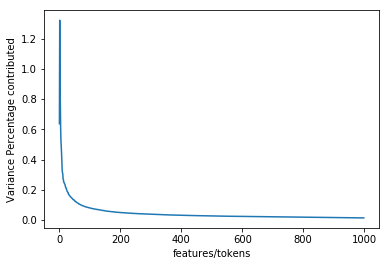

In [94]:
# plot of variance(percentage) contributed by each feature
plt.plot(np.arange(0,n_comp,1),svd.explained_variance_ratio_*100)
plt.xlabel('features/tokens')
plt.ylabel('Variance Percentage contributed')
plt.savefig('svd_variance.jpeg')

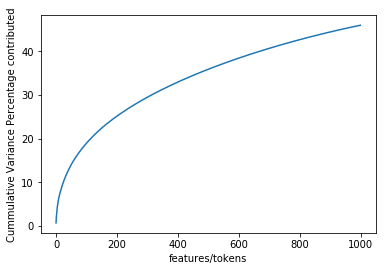

In [95]:
# commulative contribution of variance by the features
cumm = [(svd.explained_variance_ratio_*100)[:i+1].sum() for i in range(n_comp)]
plt.plot(np.arange(0,n_comp,1),cumm)
plt.xlabel('features/tokens')
plt.ylabel('Cummulative Variance Percentage contributed')
plt.savefig('svd_variance_cummulative.jpeg')

In [97]:
svd.explained_variance_ratio_.sum()*100

45.99535194001695

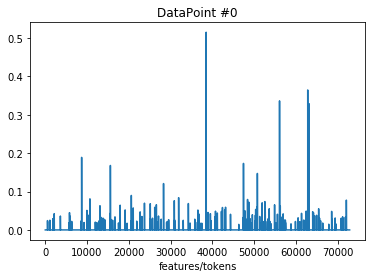

In [96]:
# plotting the tfidf vector of datapoint 0
plt.plot(np.arange(0,tfidf.shape[1],1),tfidf[0,:].todense().T)
plt.title('DataPoint #0')
plt.xlabel('features/tokens')
plt.savefig('tfidf_vector.jpeg')
plt.show()

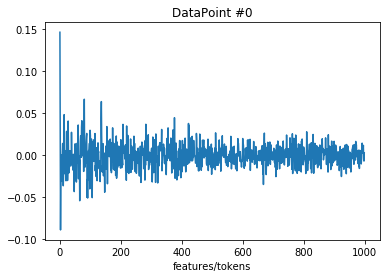

In [98]:
# plotting the reduced tfidf vector of datapoint 0
plt.plot(np.arange(0,tfidf_red.shape[1],1),tfidf_red[0,:])
plt.title('DataPoint #0')
plt.xlabel('features/tokens')
plt.savefig('tfidf_vector_reduced.jpeg')
plt.show()

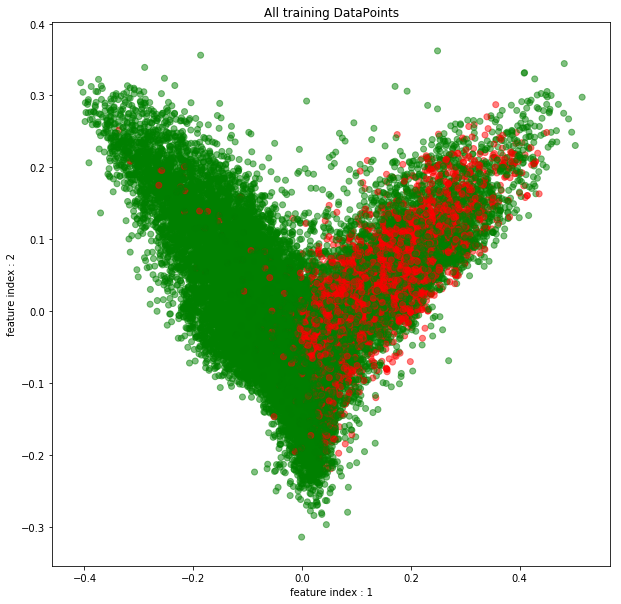

In [99]:
# Because our tfidf is not centered, the first feature after LSA reduction
# just contains information on the frequency of the words in the documents.

# Therefore, to really see any difference in features of the two types of articles,
# we will use second and third most variant features plot to see any distinction.

# for data, fak in zip(tfidf_red[:,1:3],target):
#     x, y = data
#     if(fak):
#         fake = plt.scatter(x, y, c='red', alpha=0.5)
#     else:
#         real = plt.scatter(x, y, c='green', alpha=0.5)
c = ['red' if i=='fake' else 'green' for i in train_dataset.type]

plt.figure(figsize=(10,10))
plt.scatter(tfidf_red[:,1], tfidf_red[:,2], c=c, alpha=0.5)
    
#plt.legend(('real','fake'),loc=0)
plt.xlabel('feature index : 1')
plt.ylabel('feature index : 2')
plt.title("All training DataPoints")
plt.savefig('top_two_features_visual.jpeg')
plt.show()

In [100]:
train_X = tfidf_red
train_y = np.array([1 if i=='fake' else 0 for i in train_dataset.type])

# Using the Vectorizer object fitted with the training
# data to transform the test data with same features.
test_tfidf = vector_tfidf.transform(test_dataset.body.astype('U'))

# Using the LSA's SVD object fitted with the training 
# data to transform the test data with the same features.
test_X = svd.transform(test_tfidf)
test_y = np.array([1 if i=='fake' else 0 for i in test_dataset.type])

## MODELS

### Logistic Regression

In [148]:
from sklearn.linear_model import LogisticRegression

def LogisticReg_train(X, y):
    
    clf = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', multi_class='multinomial')
    model = clf.fit(X, y)
    return model

In [149]:
%%time 
prf_f = []
prf_r = []
acc = []
for i in range(10):
    
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
    train_dataset.reset_index(drop=True, inplace=True)
    test_dataset.reset_index(drop=True, inplace=True)
    
    vector_tfidf = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=2)
    tfidf = vector_tfidf.fit_transform(train_dataset.body.astype('U'))
    
    svd = TruncatedSVD(n_components=1000, n_iter=3, algorithm='randomized')
    tfidf_red = svd.fit_transform(tfidf)
        
    train_X = tfidf_red
    train_y = np.array([1 if i=='fake' else 0 for i in train_dataset.type])
    test_tfidf = vector_tfidf.transform(test_dataset.body.astype('U'))
    test_X = svd.transform(test_tfidf)
    test_y = np.array([1 if i=='fake' else 0 for i in test_dataset.type])
    
    logReg_clf = LogisticReg_train(train_X, train_y)
    test_pred = logReg_clf.predict(test_X)
    
    prf_f.append(precision_recall_fscore_support(test_y,test_pred, pos_label=1, average='binary')[:3])
    prf_r.append(precision_recall_fscore_support(test_y,test_pred, pos_label=0, average='binary')[:3])
    
    acc = np.mean(np.equal(test_y,test_pred))
    print("{} of 10".format(i))

prf_fake = np.mean(prf_f,axis=0)
prf_real = np.mean(prf_r,axis=0)
accuracy = np.mean(acc)

print("LOGISTIC REGRESSION\n")
print("\nAccuracy : {:.2f}%".format(accuracy*100))
print('\nPrediction of Real News (0)')
print("Precision : {:.2f}%".format(prf_real[0]*100))
print("Recall : {:.2f}%".format(prf_real[1]*100))
print("F1Score : {:.2f}%".format(prf_real[2]*100))
print('\nPrediction of Fake News (1)')
print("Precision : {:.2f}%".format(prf_fake[0]*100))
print("Recall : {:.2f}%".format(prf_fake[1]*100))
print("F1Score : {:.2f}%".format(prf_fake[2]*100))

0 of 10
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
LOGISTIC REGRESSION


Accuracy : 96.59%

Prediction of Real News (0)
Precision : 96.89%
Recall : 99.03%
F1Score : 97.95%

Prediction of Fake News (1)
Precision : 95.28%
Recall : 86.02%
F1Score : 90.41%
Wall time: 41min 49s


In [150]:
prf_f

[(0.9514407684098186, 0.8567996155694377, 0.9016434892541086),
 (0.9501625135427952, 0.8739412057797707, 0.9104593822995068),
 (0.9441431670281996, 0.8623080733036157, 0.901371990680818),
 (0.9587458745874587, 0.8502439024390244, 0.9012409513960703),
 (0.9519912711402073, 0.8491484184914841, 0.8976337448559671),
 (0.9431757833244823, 0.8770370370370371, 0.9089048106448312),
 (0.9546191247974068, 0.862371888726208, 0.9061538461538462),
 (0.9549647314161693, 0.8560311284046692, 0.9027955886124647),
 (0.961261759822911, 0.8573543928923988, 0.9063396817114532),
 (0.9574582660204631, 0.8564547206165704, 0.9041444190185609)]

In [151]:
prf_r

[(0.9675204359673024, 0.9898528099910794, 0.9785592239431187),
 (0.9725089644681082, 0.9898252598982527, 0.9810907097835024),
 (0.9697990222705052, 0.98859357696567, 0.9791061146147517),
 (0.9667424981042141, 0.9916657406378486, 0.9790455293472298),
 (0.9663628472222222, 0.9902156993551257, 0.9781438769906645),
 (0.9728343879554877, 0.9881427304964538, 0.9804288070368334),
 (0.969341161121983, 0.9906666666666667, 0.9798878997692054),
 (0.9678470562676516, 0.990770599355054, 0.9791746799274685),
 (0.9687297121835101, 0.9922420480993018, 0.9803449219819326),
 (0.9675805047867712, 0.9911958096511757, 0.9792458023671897)]

In [152]:
acc

0.9658792650918635

### Support Vector Machine

In [153]:
def SupportVecMachine_train(X, y):
    
    model = svm.SVC(kernel='rbf')
    clf = model.fit(X,y)
    return clf

In [154]:
%%time 
prf_f = []
prf_r = []
acc = []
for i in range(10):
    
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
    train_dataset.reset_index(drop=True, inplace=True)
    test_dataset.reset_index(drop=True, inplace=True)
    
    vector_tfidf = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=2)
    tfidf = vector_tfidf.fit_transform(train_dataset.body.astype('U'))
    
    svd = TruncatedSVD(n_components=1000, n_iter=3, algorithm='randomized')
    tfidf_red = svd.fit_transform(tfidf)
        
    train_X = tfidf_red
    train_y = np.array([1 if i=='fake' else 0 for i in train_dataset.type])
    test_tfidf = vector_tfidf.transform(test_dataset.body.astype('U'))
    test_X = svd.transform(test_tfidf)
    test_y = np.array([1 if i=='fake' else 0 for i in test_dataset.type])
    
    svm_clf = SupportVecMachine_train(train_X[:,:50],train_y)
    test_pred = svm_clf.predict(test_X[:,:50])
    
    prf_f.append(precision_recall_fscore_support(test_y,test_pred, pos_label=1, average='binary')[:3])
    prf_r.append(precision_recall_fscore_support(test_y,test_pred, pos_label=0, average='binary')[:3])
    
    acc.append(np.mean(np.equal(test_y,test_pred)))
    print("{} of 10".format(i))

prf_fake = np.mean(prf_f,axis=0)
prf_real = np.mean(prf_r,axis=0)
accuracy = np.mean(acc)

print("SUPPORT VECTOR MACHINE\n")
print("\nAccuracy : {:.2f}%".format(accuracy*100))
print('\nPrediction of Real News (0)')
print("Precision : {:.2f}%".format(prf_real[0]*100))
print("Recall : {:.2f}%".format(prf_real[1]*100))
print("F1Score : {:.2f}%".format(prf_real[2]*100))
print('\nPrediction of Fake News (1)')
print("Precision : {:.2f}%".format(prf_fake[0]*100))
print("Recall : {:.2f}%".format(prf_fake[1]*100))
print("F1Score : {:.2f}%".format(prf_fake[2]*100))

0 of 10
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
SUPPORT VECTOR MACHINE


Accuracy : 87.45%

Prediction of Real News (0)
Precision : 87.14%
Recall : 99.23%
F1Score : 92.79%

Prediction of Fake News (1)
Precision : 91.37%
Recall : 35.83%
F1Score : 51.47%
Wall time: 53min 39s


In [155]:
prf_f

[(0.9069767441860465, 0.3571084337349398, 0.512448132780083),
 (0.9111111111111111, 0.36534653465346534, 0.5215547703180211),
 (0.9212903225806451, 0.3562874251497006, 0.5138539042821159),
 (0.927070457354759, 0.37462537462537465, 0.5336179295624333),
 (0.9072039072039072, 0.3603297769156159, 0.5157931273863242),
 (0.9171817058096415, 0.3572460279248917, 0.5142065142065142),
 (0.9256926952141058, 0.36422200198216054, 0.5227596017069701),
 (0.9007444168734491, 0.34538534728829684, 0.49931224209078406),
 (0.91125, 0.3554363725012189, 0.51139950894423),
 (0.9085290482076638, 0.3468617272298254, 0.5020491803278689)]

In [157]:
prf_r

[(0.8696247068021892, 0.9915310898150211, 0.9265854420493596),
 (0.8747924602011915, 0.9920256949828331, 0.9297280465019722),
 (0.8744403348257738, 0.9932559425096739, 0.9300688441430717),
 (0.877734375, 0.9934785011606058, 0.9320267537719708),
 (0.8710654936461388, 0.9915433403805497, 0.9274080241452881),
 (0.86962890625, 0.9925323227819884, 0.9270247761815532),
 (0.8748902974158946, 0.993466947181929, 0.930415845691175),
 (0.8656643561456604, 0.9910584553481614, 0.9241271495570609),
 (0.8710118060298566, 0.99210935763503, 0.9276250844287423),
 (0.86484375, 0.9917133258678611, 0.923943661971831)]

In [156]:
acc

[0.8723866413250068,
 0.8774549733007512,
 0.8777264910851661,
 0.8813467282106978,
 0.8737442302470811,
 0.8731106887501131,
 0.8785410444384107,
 0.8682233686306453,
 0.8739252421033578,
 0.8680423567743687]

### Random Forest

In [158]:
from sklearn.ensemble import RandomForestClassifier

def RandomForest_train(X, y):
    
    model = RandomForestClassifier(n_estimators=100, criterion='gini')
    clf = model.fit(X,y)
    return clf

In [172]:
%%time 
prf_f = []
prf_r = []
acc = []
for i in range(10):
    
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
    train_dataset.reset_index(drop=True, inplace=True)
    test_dataset.reset_index(drop=True, inplace=True)
    
    vector_tfidf = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=2)
    tfidf = vector_tfidf.fit_transform(train_dataset.body.astype('U'))
    
    svd = TruncatedSVD(n_components=1000, n_iter=3, algorithm='randomized')
    tfidf_red = svd.fit_transform(tfidf)
        
    train_X = tfidf_red
    train_y = np.array([1 if i=='fake' else 0 for i in train_dataset.type])
    test_tfidf = vector_tfidf.transform(test_dataset.body.astype('U'))
    test_X = svd.transform(test_tfidf)
    test_y = np.array([1 if i=='fake' else 0 for i in test_dataset.type])
    
    randforest_clf = RandomForest_train(train_X, train_y)
    test_pred = randforest_clf.predict(test_X)
    
    prf_f.append(precision_recall_fscore_support(test_y,test_pred, pos_label=1, average='binary')[:3])
    prf_r.append(precision_recall_fscore_support(test_y,test_pred, pos_label=0, average='binary')[:3])
    
    acc.append(np.mean(np.equal(test_y,test_pred)))
    print("{} of 10".format(i))

prf_fake = np.mean(prf_f,axis=0)
prf_real = np.mean(prf_r,axis=0)
accuracy = np.mean(acc)

print("RANDOM FOREST\n")
print("\nAccuracy : {:.2f}%".format(accuracy*100))
print('\nPrediction of Real News (0)')
print("Precision : {:.2f}%".format(prf_real[0]*100))
print("Recall : {:.2f}%".format(prf_real[1]*100))
print("F1Score : {:.2f}%".format(prf_real[2]*100))
print('\nPrediction of Fake News (1)')
print("Precision : {:.2f}%".format(prf_fake[0]*100))
print("Recall : {:.2f}%".format(prf_fake[1]*100))
print("F1Score : {:.2f}%".format(prf_fake[2]*100))

0 of 10
1 of 10
2 of 10
3 of 10
4 of 10
5 of 10
6 of 10
7 of 10
8 of 10
9 of 10
RANDOM FOREST


Accuracy : 90.45%

Prediction of Real News (0)
Precision : 89.72%
Recall : 99.69%
F1Score : 94.45%

Prediction of Fake News (1)
Precision : 97.37%
Recall : 49.71%
F1Score : 65.80%
Wall time: 1h 27min 35s


In [173]:
prf_f

[(0.9735294117647059, 0.47878495660559306, 0.6418875242404654),
 (0.9690063810391978, 0.5192965315095261, 0.676208651399491),
 (0.9741626794258373, 0.503960396039604, 0.6642740619902121),
 (0.9705304518664047, 0.4935064935064935, 0.6543046357615894),
 (0.9818731117824774, 0.47192642787996125, 0.6374632232755802),
 (0.9731977818853974, 0.5033460803059273, 0.6635160680529301),
 (0.9703153988868275, 0.5109916951636542, 0.66944),
 (0.9733464955577492, 0.48238747553816047, 0.6450768727510632),
 (0.9696969696969697, 0.4935323383084577, 0.654137817342565),
 (0.9812734082397003, 0.5132223310479922, 0.6739549839228296)]

In [174]:
prf_r

[(0.8922125835078273, 0.996991643454039, 0.9416964849505367),
 (0.9011254019292605, 0.9962230615418796, 0.9462910203650945),
 (0.8998400639744102, 0.9970096356185624, 0.9459360058845164),
 (0.8989133685574718, 0.996683983640986, 0.9452772827340391),
 (0.8915075576770087, 0.9979962150729155, 0.9417511423919324),
 (0.8957559947827832, 0.9967623088087529, 0.9435637285986049),
 (0.8996088657105606, 0.9964452343923572, 0.9455542086122385),
 (0.8945795137504982, 0.9970016657412548, 0.943017698650281),
 (0.8984639936165969, 0.9965704170815356, 0.9449777078415945),
 (0.9004107804829176, 0.997779504829577, 0.9465978512744891)]

In [175]:
acc

[0.8997194316227712,
 0.9078649651552176,
 0.9068693999456965,
 0.905511811023622,
 0.899628925694633,
 0.903339668748303,
 0.9065073762331433,
 0.9018010679699521,
 0.9050592813829306,
 0.9082269888677709]

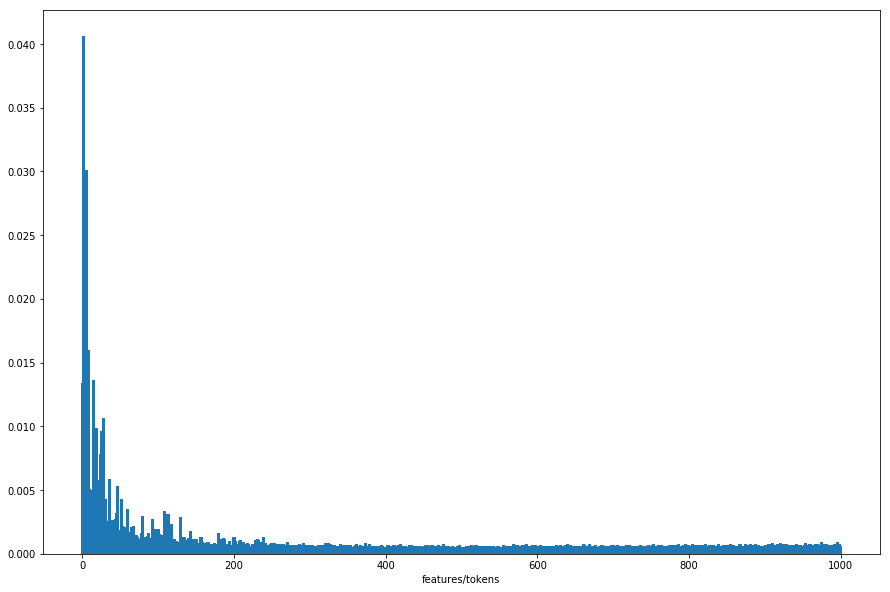

In [176]:
plt.figure(figsize=(15,10))
plt.bar(np.arange(0,train_X.shape[1],1),randforest_clf.feature_importances_,width=4)
plt.xlabel("features/tokens")
plt.savefig('randomForest_feature_importance.jpeg')
plt.show()

### Feed-Forward Neural Network Model

In [200]:
def nn_train(train_X, train_y, epoch=2):
    
    feats = train_X.shape[1]
    
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(600, input_shape=(feats,), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(300, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(train_X, train_y, epochs=epoch,verbose=1)
    return model

In [202]:
%%time 
prf_f = []
prf_r = []
acc = []
for i in range(10):
    
    train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
    train_dataset.reset_index(drop=True, inplace=True)
    test_dataset.reset_index(drop=True, inplace=True)
    
    vector_tfidf = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=2)
    tfidf = vector_tfidf.fit_transform(train_dataset.body.astype('U'))
    
    svd = TruncatedSVD(n_components=1000, n_iter=3, algorithm='randomized')
    tfidf_red = svd.fit_transform(tfidf)
        
    train_X = tfidf_red
    train_y = np.array([1 if i=='fake' else 0 for i in train_dataset.type])
    test_tfidf = vector_tfidf.transform(test_dataset.body.astype('U'))
    test_X = svd.transform(test_tfidf)
    test_y = np.array([1 if i=='fake' else 0 for i in test_dataset.type])
    
    NN_clf = nn_train(train_X, train_y, epoch=2)
    test_pred = NN_clf.predict(test_X)
    test_pred = ((test_pred>0.5)*1).flatten()
    
    prf_f.append(precision_recall_fscore_support(test_y,test_pred, pos_label=1, average='binary')[:3])
    prf_r.append(precision_recall_fscore_support(test_y,test_pred, pos_label=0, average='binary')[:3])
    
    acc.append(np.mean(np.equal(test_y,test_pred)))
    print("{} of 10".format(i))

prf_fake = np.mean(prf_f,axis=0)
prf_real = np.mean(prf_r,axis=0)
accuracy = np.mean(acc)

print("Feed-Forward Neural Network Model\n")
print("\nAccuracy : {:.2f}%".format(accuracy*100))
print('\nPrediction of Real News (0)')
print("Precision : {:.2f}%".format(prf_real[0]*100))
print("Recall : {:.2f}%".format(prf_real[1]*100))
print("F1Score : {:.2f}%".format(prf_real[2]*100))
print('\nPrediction of Fake News (1)')
print("Precision : {:.2f}%".format(prf_fake[0]*100))
print("Recall : {:.2f}%".format(prf_fake[1]*100))
print("F1Score : {:.2f}%".format(prf_fake[2]*100))

Epoch 1/2
44194/44194 [==============================] - 35s 784us/step - loss: 0.1220 - acc: 0.9511
Epoch 2/2
44194/44194 [==============================] - 34s 774us/step - loss: 0.0643 - acc: 0.9765
0 of 10
Epoch 1/2
44194/44194 [==============================] - 43s 980us/step - loss: 0.1210 - acc: 0.9526
Epoch 2/2
44194/44194 [==============================] - 49s 1ms/step - loss: 0.0641 - acc: 0.9767: 0s - loss: 0.0642 - a
1 of 10
Epoch 1/2
44194/44194 [==============================] - 40s 906us/step - loss: 0.1202 - acc: 0.9536
Epoch 2/2
44194/44194 [==============================] - 39s 885us/step - loss: 0.0647 - acc: 0.9767
2 of 10
Epoch 1/2
44194/44194 [==============================] - 34s 775us/step - loss: 0.1213 - acc: 0.9526
Epoch 2/2
44194/44194 [==============================] - 34s 763us/step - loss: 0.0643 - acc: 0.97591s - loss: 0
3 of 10
Epoch 1/2
44194/44194 [==============================] - 35s 799us/step - loss: 0.1203 - acc: 0.9535
Epoch 2/2
44194/44194 [===

In [203]:
train_X.shape

(44194, 1000)

In [204]:
prf_f

[(0.9021791767554479, 0.9347717009533367, 0.9181862986692952),
 (0.9487051792828686, 0.9019886363636364, 0.924757281553398),
 (0.9498708010335918, 0.9090009891196835, 0.9289866060146577),
 (0.9099756690997567, 0.9289617486338798, 0.9193706981317601),
 (0.9598732840549102, 0.873618452666987, 0.9147169811320754),
 (0.9414784394250514, 0.9016715830875123, 0.9211451531893521),
 (0.9575916230366492, 0.8852855759922555, 0.920020120724346),
 (0.9503073770491803, 0.9210526315789473, 0.9354513363590519),
 (0.9185185185185185, 0.9340866290018832, 0.9262371615312791),
 (0.9412955465587044, 0.9090909090909091, 0.9249129786176031)]

In [205]:
prf_r

[(0.9855298308103295, 0.9776943462897526, 0.9815964523281597),
 (0.9771043026213915, 0.9884748797135504, 0.9827567026365558),
 (0.9798112793504499, 0.9892544588456852, 0.9845102254561492),
 (0.9841005114520792, 0.9795263390880921, 0.981808097615086),
 (0.9712725286728564, 0.9915254237288136, 0.9812944876676046),
 (0.9780243929238546, 0.9873544093178036, 0.9826672554647825),
 (0.9740671845935004, 0.9909829678281198, 0.9824522679615936),
 (0.9825217104539958, 0.9892639734366353, 0.985881314802559),
 (0.9842501968725391, 0.9802801120448179, 0.982261142921298),
 (0.9794996142400529, 0.9871154059757858, 0.9832927638858154)]

In [206]:
acc

[0.9699520318580866,
 0.9719431622771292,
 0.9745678341931396,
 0.9703140555706399,
 0.9693184903611186,
 0.971581138564576,
 0.9712191148520228,
 0.976830482396597,
 0.9714001267082993,
 0.9726672097022355]

In [275]:
test_pred = NN_clf.predict(test_X)
test_pred = ((test_pred>0.5)*1).flatten()
### confusion matrix ###
cm = pd.crosstab(test_pred, test_y, rownames=['Predicted'], colnames=['True'], margins = True)

### classification report ###
prf_fake = precision_recall_fscore_support(test_y,test_pred, pos_label=1, average='binary')
prf_real = precision_recall_fscore_support(test_y,test_pred, pos_label=0, average='binary')

acc = np.mean(np.equal(test_y,test_pred))

print("Feed-Forward Neural Network Model\n")
print('--------Confusion Matrix-------\n')
print(cm)
print("\nAccuracy : {:.2f}%".format(acc*100))
print('\nPrediction of Real News (0)')
print("Precision : {:.2f}%".format(prf_real[0]*100))
print("Recall : {:.2f}%".format(prf_real[1]*100))
print("F1Score : {:.2f}%".format(prf_real[2]*100))
print('\nPrediction of Fake News (1)')
print("Precision : {:.2f}%".format(prf_fake[0]*100))
print("Recall : {:.2f}%".format(prf_fake[1]*100))
print("F1Score : {:.2f}%".format(prf_fake[2]*100))

Feed-Forward Neural Network Model

--------Confusion Matrix-------

True          0     1    All
Predicted                   
0          8808   140   8948
1           208  1893   2101
All        9016  2033  11049

Accuracy : 96.85%

Prediction of Real News (0)
Precision : 98.44%
Recall : 97.69%
F1Score : 98.06%

Prediction of Fake News (1)
Precision : 90.10%
Recall : 93.11%
F1Score : 91.58%


### Reccurant Neural Network 

In [15]:
def filter_text(text):
    # removing html tags
    text = re.sub("<.*?>","",text)
    # removing websites, email addresses or any punctuation
    # changing "*http(s)*", "*www*" or "*@*" to " "
    # \S+ means anything except whitespace char >=1 times
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", "", text)
    # changing anything except alphabets to " "
    text = re.sub("[^a-zA-Z]"," ",text)
    text = text.lower()
    return text


In [18]:
from nltk.tokenize import word_tokenize
# the dataset is cleaned of any special characters,
# and word stemming is done to remove any words with almost similar meaning and
# hence will help reduce the tf-idf dimensionality (number of unique words)
def clean_text(dataset):
    t0 = time()

    for i in dataset.index:
        # we will crop the first 1000 words for every article under assumption that 
        # we can learn the article's 'fakeness' from first 1000 words
        dataset.at[i,'body'] = ' '.join(filter_text(dataset.body[i]).split()[:1000])

    print("Time taken to cleanUp : %.3f min" % ((time()-t0)/60))


In [19]:
# removing empty/nan article bodies and articles with less that 100 words
fake_dataset = filter_nan(fake_news)
real_dataset = filter_nan(real_news)

In [20]:
# reducing the number of real_dataset datapoints around that of fake_dataset
# keeping the fake to non-fake news ratio close to presence in real world media
real_dataset = real_dataset.sample(n=45000,random_state=42)
real_dataset.reset_index(drop=True, inplace=True)

In [21]:
dataset = pd.concat([real_dataset,fake_dataset])
dataset.reset_index(drop=True, inplace=True)

In [22]:
clean_text(dataset)

Time taken to cleanUp : 6.562 min


In [23]:
dataset = filter_nan(dataset)

#### Data Pre-Processing

In [24]:
%%time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

label = np.array([1 if t=='fake' else 0 for t in dataset.type])

# create a tokenizer object 
tokenizer = Tokenizer()
# fit on all the list of news articles will
# create a dictionary of unique word occurances
tokenizer.fit_on_texts(dataset.body)
# convert each article to a sequence of integers
sequences = tokenizer.texts_to_sequences(dataset.body)

# word_index contains the dictionary of unique words
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# padding each sequence with 0 to make the input constant len of maximum size sequence
data = pad_sequences(sequences,padding='post',maxlen=1000)

# shuffling and creating test and train set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
label = label[indices]

test_size = 0.2

test_samples = int(test_size*data.shape[0])
train_X = data[:-test_samples]
train_y = label[:-test_samples]
test_X = data[-test_samples:]
test_y = label[-test_samples:]

Found 187279 unique tokens.
Wall time: 1min


In [25]:
train_X.shape

(44184, 1000)

In [27]:
embedding_dim = 100
# +1 for the 0th index corresponding <unk> words 
vocab_size = len(word_index) + 1
units = 100
timesteps = train_X.shape[1]

In [26]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    
f.close()
print('words found :',len(embeddings_index))

words found : 400000


In [28]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    # if word not in embedding_index then the wordvec remains 0s
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [29]:
embedding_matrix.shape

(187280, 100)

In [30]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                    embedding_dim,
                                    weights = [embedding_matrix],
                                    input_length = train_X.shape[1],
                                    trainable=False))
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv1D(64,4,activation='relu'))
# model.add(tf.keras.layers.MaxPool1D(pool_size=4))
model.add(tf.keras.layers.LSTM(units,
                               input_shape = (timesteps,embedding_dim),
                               recurrent_activation = 'sigmoid',
                               return_sequences = False,             # this means to carry forward the OUTPUT of units
                               recurrent_initializer = 'glorot_uniform',
                               ))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         18728000  
_________________________________________________________________
conv1d (Conv1D)              (None, 997, 64)           25664     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               66000     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 18,819,765
Trainable params: 91,765
Non-trainable params: 18,728,000
_________________________________________________________________


In [31]:
model.fit(train_X, train_y, epochs=2)

Epoch 1/2
44184/44184 [==============================] - 2529s 57ms/step - loss: 0.4728 - acc: 0.8150
Epoch 2/2
44184/44184 [==============================] - 2439s 55ms/step - loss: 0.3251 - acc: 0.8612


In [35]:
test_pred = model.predict(test_X)
test_pred = ((test_pred>0.5)*1).flatten()
### confusion matrix ###
cm = pd.crosstab(test_pred, test_y, rownames=['Predicted'], colnames=['True'], margins = True)

### classification report ###
prf_fake = precision_recall_fscore_support(test_y,test_pred, pos_label=1, average='binary')
prf_real = precision_recall_fscore_support(test_y,test_pred, pos_label=0, average='binary')

acc = np.mean(np.equal(test_y,test_pred))

print("LSTM Network Model\n")
print('--------Confusion Matrix-------\n')
print(cm)
print("\nAccuracy : {:.2f}%".format(acc*100))
print('\nPrediction of Real News (0)')
print("Precision : {:.2f}%".format(prf_real[0]*100))
print("Recall : {:.2f}%".format(prf_real[1]*100))
print("F1Score : {:.2f}%".format(prf_real[2]*100))
print('\nPrediction of Fake News (1)')
print("Precision : {:.2f}%".format(prf_fake[0]*100))
print("Recall : {:.2f}%".format(prf_fake[1]*100))
print("F1Score : {:.2f}%".format(prf_fake[2]*100))

LSTM Network Model

--------Confusion Matrix-------

True          0     1    All
Predicted                   
0          8586   537   9123
1           377  1546   1923
All        8963  2083  11046

Accuracy : 91.73%

Prediction of Real News (0)
Precision : 94.11%
Recall : 95.79%
F1Score : 94.95%

Prediction of Fake News (1)
Precision : 80.40%
Recall : 74.22%
F1Score : 77.18%
